In [1]:
# Import the QICK drivers and auxiliary libraries
from qick import *
import matplotlib.pyplot as plt
import numpy as np
# from scipy.signal import find_peaks
# %pylab inline

In [2]:
# qick_path = "/home/xilinx/jupyter_notebooks/fw/2024-06-14_4x2_commonclk-4pt9/qick_4x2.bit"
# qick_path = "/home/xilinx/jupyter_notebooks/fw/2024-10-18_4x2_commonclk-4pt9-debug/qick_4x2.bit"
qick_path = "/home/xilinx/jupyter_notebooks/fw/2024-10-18_4x2_commonclk-4pt9-nodebug/qick_4x2.bit"

In [3]:
soc = QickSoc(bitfile=qick_path)
soccfg = soc
print(soccfg)

QICK running on RFSoC4x2, software version 0.2.295

Firmware configuration (built Fri Oct 18 16:58:49 2024):

	Global clocks (MHz): tProcessor 307.200, RF reference 409.600

	2 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (13.333 us)
		fs=4915.200 MHz, fabric=307.200 MHz, 32-bit DDS, range=4915.200 MHz
		DAC tile 0, blk 0 is DAC_B
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (13.333 us)
		fs=4915.200 MHz, fabric=307.200 MHz, 32-bit DDS, range=4915.200 MHz
		DAC tile 2, blk 0 is DAC_A

	2 readout channels:
	0:	axis_readout_v2 - configured by PYNQ
		fs=2457.600 MHz, decimated=307.200 MHz, 32-bit DDS, range=2457.600 MHz
		axis_avg_buffer v1.1 (has edge counter)
		maxlen 16384 accumulated, 1024 decimated (3.333 us)
		triggered by output 7, pin 14, feedback to tProc input 0
		ADC tile 0, blk 0 is ADC_D
	1:	axis_readout_v2 - configured by PYNQ
		fs=2457.600 MHz, decimated=307.200 MHz, 32-bit DDS, range=2457.600 MHz
		axis_avg_buffer v1.1 (has ed

Let's start with a simple program that doesn't play pulses, it just runs a readout in edge-counting mode.

Note that we disable downconversion in the readout using `sel='input'` and `freq=0`. This is what you want if you're counting DC-coupled pulses from a photodiode or similar. However, the edge counter will also work on downconverted RF pulses - it will just look at the I component of the signal.

For DC-coupled pulses, you will also want to use an ADC with a DC-coupled amplifier instead of a balun (see [QICK-DAWG](https://github.com/sandialabs/qick-dawg) for information on setting up a RFSoC4x2 in this configuration). However, I am running this demo with an unmodified RFSoC4x2 (which is fine, because I'm not looking at real pulses).

In [116]:
class ReadoutProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg   
        
        self.declare_readout(ch=self.cfg['ro_ch'], length=self.cfg['readout_length'], freq=0,
                             sel='input',
                             edge_counting=True,
                             high_threshold=cfg['high_threshold'],
                             low_threshold=cfg['low_threshold'],
                            )
        
        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        self.trigger(adcs=[self.cfg['ro_ch']], 
                     adc_trig_offset=self.cfg["adc_trig_offset"])
        self.wait_all()
        self.sync_all(self.us2cycles(self.cfg['relax_delay']))

In [109]:
def find_edges(samples, thresh_h, thresh_l):
    """Emulate the edge-counting algorithm on decimated data.
    """
    edges = []
    h_state = True
    for i, sample in enumerate(samples):
        last_state = h_state
        if sample > thresh_h:
            h_state = True
        elif sample < thresh_l:
            h_state = False
        if h_state and not last_state:
            edges.append(i)
    return edges

Let's test the edge counter by comparing the counter output to the decimated trace. The edge counter agrees with what we get by counting edges in software. (Sometimes the firmware edge counter finds one extra edge - not sure why. But we have never seen it count an edge in a trace that contained no edges.)

Here we're just looking at noise, but if you have a pulse generator or photon detector you could look at that. In either case you may need to adjust the thresholds and readout length as appropriate for your setup.

firmware count=8, software count=8


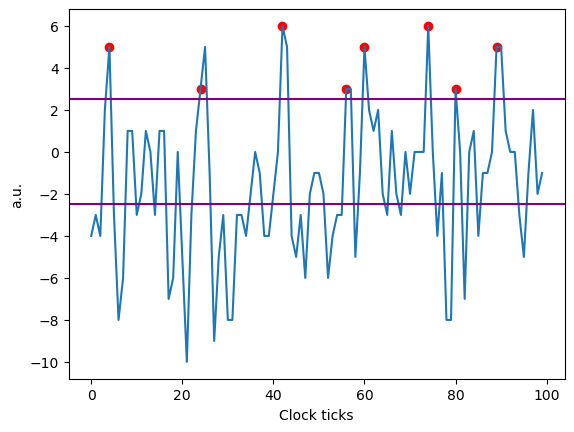

In [117]:
config={"ro_ch": 0,
        "reps": 1,
        "relax_delay":10, # --us        
        "readout_length":100, # [RO clock ticks]
        "adc_trig_offset": 100, # [tProc clock ticks]
        "high_threshold": 2,
        "low_threshold": -2,
        "soft_avgs":1
       }

prog =ReadoutProgram(soccfg, config)
iq_list = prog.acquire_decimated(soc, progress=False)

samples = iq_list[0][0]
counts = prog.get_raw()[0][0,0,0]

edges = find_edges(samples, config['high_threshold'], config['low_threshold'])
print("firmware count=%d, software count=%d"%(counts, len(edges)))

# Plot results.
plt.figure(1)
plt.plot(samples)
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")

plt.axhline(config['high_threshold']+0.5, color='purple')
plt.axhline(config['low_threshold']-0.5, color='purple')

if len(edges)>0: plt.scatter(edges, samples[edges], c='red');


Now let's make the readout window longer (100 us) and do 1000 reps.

Similarly to standard readout, you can get the average result from the output of `acquire()` or use `get_raw()` to get shot-by-shot results. Note that unlike standard readout, the output of `acquire()` is not normalized to the window length (the result is in counts, not counts-per-tick, whereas for normal readout the result is ADU-per-tick).

  0%|          | 0/1000 [00:00<?, ?it/s]

average count=1574.543


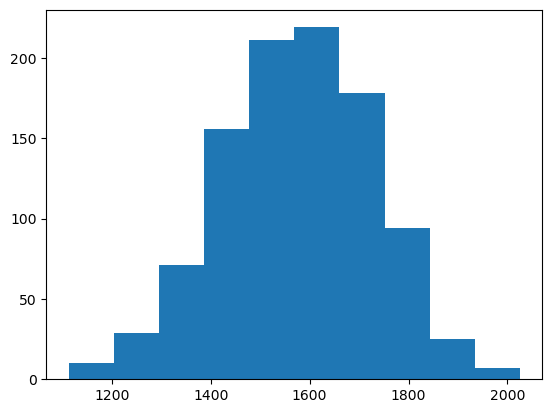

In [115]:
config['reps'] = 1000
config['readout_length'] = soccfg.us2cycles(100, ro_ch=config['ro_ch'])
prog =ReadoutProgram(soccfg, config)

iq_list = prog.acquire(soc)
mean_counts = iq_list[0][0][0]
print("average count=%.3f"%(mean_counts))

counts = prog.get_raw()[0][:,0,0]

plt.hist(counts);

Now let's play pulses in loopback, and count them.

We're going to configure the generator in periodic mode, where it plays the defined pulse repeatedly without gaps.

In [150]:
class LoopbackProgramDC(AveragerProgram):
    def initialize(self):
        cfg=self.cfg
        
        self.declare_readout(ch=cfg['ro_ch'], length=cfg['readout_length'], freq=0,
                             edge_counting=True,
                             high_threshold=cfg['high_threshold'],
                             low_threshold=cfg['low_threshold'],
                            )
        
        gen_ch = cfg['gen_ch']
        
        # define a pulse envelope that's high for pulse_length, and 0 the rest of the time
        idata = np.zeros(16*self.us2cycles(cfg['pulse_period'], gen_ch=gen_ch))
        idata[:16*self.us2cycles(cfg['pulse_length'], gen_ch=gen_ch)] = 30000
        
        self.declare_gen(ch=gen_ch, nqz=1)
        self.add_pulse(ch=gen_ch, name="pulse", idata=idata)
        
        self.set_pulse_registers(ch=gen_ch, style="arb", freq=0, phase=0, gain=10000, 
                                     waveform="pulse", mode="periodic")
        self.pulse(ch=gen_ch, t=0)

        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        self.trigger(adcs=[0,1],adc_trig_offset=self.cfg["adc_trig_offset"])  # trigger the adc acquisition
        for ch in self.cfg['out_ch']:
            self.pulse(ch=ch, t=0) # play readout pulse
        
        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        self.trigger(adcs=[self.cfg['ro_ch']], 
                     adc_trig_offset=self.cfg["adc_trig_offset"])
        self.wait_all()
        self.sync_all(self.us2cycles(self.cfg['relax_delay']))

Observe how the baluns distort the pulse shape (baluns block DC, which is roughly equivalent to differentiating the pulse). But we're able to count the rising edges.

firmware count=3, software count=3


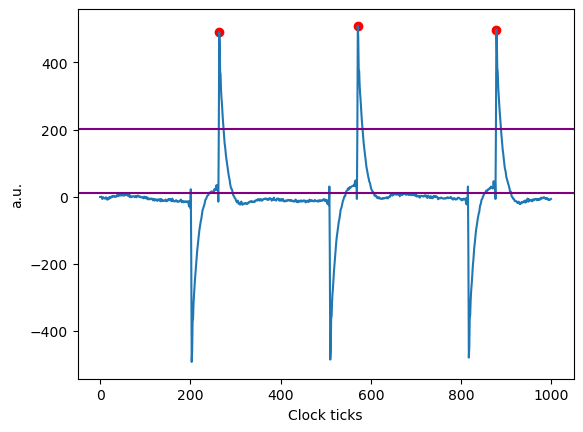

In [193]:
config={"ro_ch": 0,
        "gen_ch": 0,
        "reps": 1,
        "relax_delay": 10, # --us
        "pulse_period": 1, # --us
        "pulse_length": 0.2, # --us
        "readout_length":1000, # [RO clock ticks]
        "adc_trig_offset": 100, # [tProc clock ticks]
        "high_threshold": 200,
        "low_threshold": 10,
        "soft_avgs":1
       }

prog =LoopbackProgramDC(soccfg, config)
iq_list = prog.acquire_decimated(soc, progress=False)
# stop the periodic pulsing, because otherwise it will continue forever
soc.reset_gens()

samples = iq_list[0][0]
counts = prog.get_raw()[0][0,0,0]

edges = find_edges(samples, config['high_threshold'], config['low_threshold'])
print("firmware count=%d, software count=%d"%(counts, len(edges)))

# Plot results.
plt.figure(1)
plt.plot(samples)
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")

plt.axhline(config['high_threshold']+0.5, color='purple')
plt.axhline(config['low_threshold']-0.5, color='purple')

if len(edges)>0: plt.scatter(edges, samples[edges], c='red');


If we again run longer readouts, we can see that we get 100 pulses in our 100-us window. Good.

  0%|          | 0/1000 [00:00<?, ?it/s]

average count=100.065


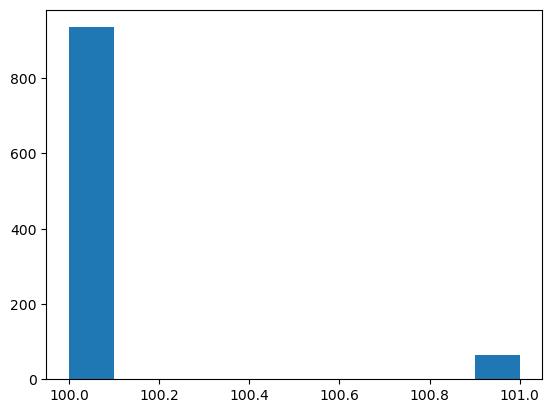

In [194]:
config['reps'] = 1000
config['readout_length'] = soccfg.us2cycles(100, ro_ch=config['ro_ch'])
prog =LoopbackProgramDC(soccfg, config)

iq_list = prog.acquire(soc)
mean_counts = iq_list[0][0][0]
print("average count=%.3f"%(mean_counts))

counts = prog.get_raw()[0][:,0,0]
plt.hist(counts);

Let's repeat with RF pulses.

In [164]:
class LoopbackProgramRF(AveragerProgram):
    def initialize(self):
        cfg=self.cfg
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_readout(ch=cfg['ro_ch'], length=cfg['readout_length'], freq=cfg['freq'],
                             gen_ch=gen_ch,
                             phase=cfg['ro_phase'],
                             edge_counting=True,
                             high_threshold=cfg['high_threshold'],
                             low_threshold=cfg['low_threshold'],
                            )
        
        gen_freq = self.freq2reg(cfg['freq'], gen_ch=gen_ch, ro_ch=ro_ch)
        
        # define a pulse envelope that's high for pulse_length, and 0 the rest of the time
        idata = np.zeros(16*self.us2cycles(cfg['pulse_period'], gen_ch=gen_ch))
        idata[:16*self.us2cycles(cfg['pulse_length'], gen_ch=gen_ch)] = 30000
        
        self.declare_gen(ch=gen_ch, nqz=1)
        self.add_pulse(ch=gen_ch, name="pulse", idata=idata)
        
        self.set_pulse_registers(ch=gen_ch, style="arb", freq=gen_freq, phase=0, gain=10000, 
                                     waveform="pulse", mode="periodic")
        self.pulse(ch=gen_ch, t=0)

        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        self.trigger(adcs=[0,1],adc_trig_offset=self.cfg["adc_trig_offset"])  # trigger the adc acquisition
        for ch in self.cfg['out_ch']:
            self.pulse(ch=ch, t=0) # play readout pulse
        
        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        self.trigger(adcs=[self.cfg['ro_ch']], 
                     adc_trig_offset=self.cfg["adc_trig_offset"])
        self.wait_all()
        self.sync_all(self.us2cycles(self.cfg['relax_delay']))

Since the edge counter looks at the I component, we want to rotate the readout phase to put our signal on the I axis.

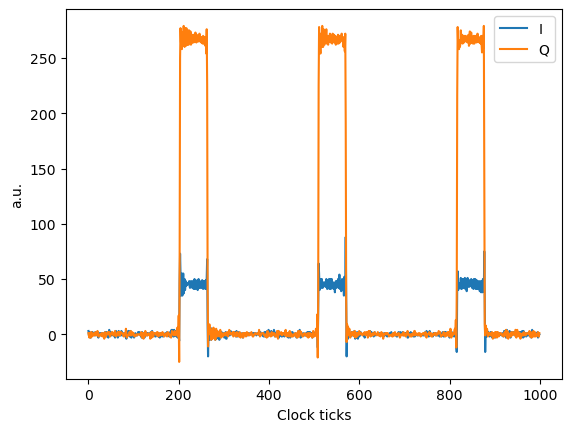

In [197]:
config={"ro_ch": 0,
        "gen_ch": 0,
        "reps": 1,
        "relax_delay": 10, # --us
        "pulse_period": 1, # --us
        "pulse_length": 0.2, # --us
        "readout_length":1000, # [RO clock ticks]
        "adc_trig_offset": 100, # [tProc clock ticks]
        "freq": 100,
        "ro_phase": 0, # degrees
        "high_threshold": 100,
        "low_threshold": 10,
        "soft_avgs":1
       }

prog =LoopbackProgramRF(soccfg, config)
iq_list = prog.acquire_decimated(soc, progress=False)
# stop the periodic pulsing, because otherwise it will continue forever
soc.reset_gens()

plt.plot(iq_list[0][0], label='I')
plt.plot(iq_list[0][1], label='Q')
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.legend()

config['ro_phase'] = -np.angle(np.mean(iq_list[0][0] + 1j*iq_list[0][1]), deg=True)

Now we can look at the counts, which look good.

firmware count=3, software count=3


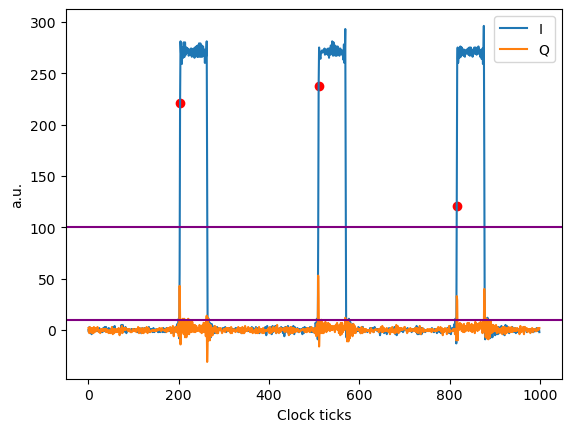

In [198]:
config={"ro_ch": 0,
        "gen_ch": 0,
        "reps": 1,
        "relax_delay": 10, # --us
        "pulse_period": 1, # --us
        "pulse_length": 0.2, # --us
        "readout_length":1000, # [RO clock ticks]
        "adc_trig_offset": 100, # [tProc clock ticks]
        "freq": 100,
        "ro_phase": -80, # degrees
        "high_threshold": 100,
        "low_threshold": 10,
        "soft_avgs":1
       }

prog =LoopbackProgramRF(soccfg, config)
iq_list = prog.acquire_decimated(soc, progress=False)
# stop the periodic pulsing, because otherwise it will continue forever
soc.reset_gens()

counts = prog.get_raw()[0][0,0,0]

edges = find_edges(iq_list[0][0], config['high_threshold'], config['low_threshold'])
print("firmware count=%d, software count=%d"%(counts, len(edges)))

# Plot results.
plt.plot(iq_list[0][0], label='I')
plt.plot(iq_list[0][1], label='Q')
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.legend()

plt.axhline(config['high_threshold']+0.5, color='purple')
plt.axhline(config['low_threshold']-0.5, color='purple')

if len(edges)>0: plt.scatter(edges, iq_list[0][0][edges], c='red');

  0%|          | 0/1000 [00:00<?, ?it/s]

average count=100.067


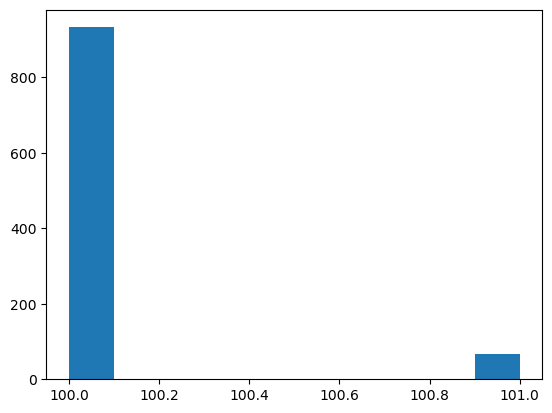

In [199]:
config['reps'] = 1000
config['readout_length'] = soccfg.us2cycles(100, ro_ch=config['ro_ch'])
prog =LoopbackProgramRF(soccfg, config)

iq_list = prog.acquire(soc)
mean_counts = iq_list[0][0][0]
print("average count=%.3f"%(mean_counts))

counts = prog.get_raw()[0][:,0,0]
plt.hist(counts);